## Dog Breed Prediction using CNN

In [1]:
#Connecting Kaggle API to colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivanirana63","key":"ede773788221a2caea069879bd8937fd"}'}

In [2]:
#Install Kaggle API Client
!pip install -q kaggle

In [3]:
#Setting up Kaggle using Kaggle api
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#create working directory and changing current directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
#searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  
---------------------------------  ----------------------  -----  -------------------  -------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05             66  


In [6]:
#Download dataset into current directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 98% 676M/691M [00:05<00:00, 147MB/s]
100% 691M/691M [00:05<00:00, 127MB/s]
/content


In [7]:
#Unzip the dataset file and remove unnecessary files
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv


Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [41]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
import keras
from keras import optimizers


In [10]:
#Reading the labels csv file
labels = pd.read_csv('dog_dataset/labels.csv')
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [11]:
labels.shape

(10222, 2)

In [17]:
breeds = labels['breed']
breeds.value_counts().head()


scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [20]:
#selecting only frist 3 breeds due to computation power
class_names = ['scottish_deerhound','maltese_dog','afghan_hound']
selected_labels = labels[(labels['breed'].isin(class_names))]
selected_labels = selected_labels.reset_index()
selected_labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,146,0379145880ad3978f9b80f0dc2c03fba,afghan_hound


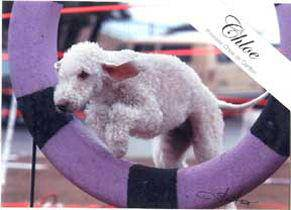

In [25]:
#displaying a random image from the data
from IPython.display import display, Image
Image("/content/dog_dataset/train/0097c6242c6f3071762d9f85c3ef1b2f.jpg")

In [22]:
#One-Hot Encoding the target values
Y_data = label_binarize(selected_labels['breed'] ,classes=class_names)

In [30]:
#Creating numpy matrix with zeros
X_data = np.zeros((len(selected_labels),224,224,3),dtype='float32')

#Read images and convert them into numpy array
for i in tqdm(range(len(selected_labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % selected_labels['id'][i], target_size= (224,224))
  img = image.img_to_array(img)
  x= np.expand_dims(img.copy(),axis=0)
  X_data[i]= x/255.0


100%|██████████| 359/359 [00:01<00:00, 210.96it/s]


In [32]:
#printing shape of X_data & Y_data
print('Train img data shape :',X_data.shape)
print('Output shape:',Y_data.shape)

Train img data shape : (359, 224, 224, 3)
Output shape: (359, 3)


In [51]:
#Building Model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5,5),activation='relu',input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(7,7),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=8, kernel_size=(5,5),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(228,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(len(class_names), activation ='softmax'))

from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001),metrics=['accuracy'])

model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 108, 108, 32)      18464     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 48, 48, 16)        25104     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 20, 20, 8)       

In [52]:
#split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data, test_size=0.2)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((287, 224, 224, 3), (72, 224, 224, 3), (287, 3), (72, 3))

In [53]:
#Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train,Y_train, batch_size= batch_size , epochs= epochs, validation_data=(X_test,Y_test))

Epoch 1/100
3/3 [==============================] - 45s 11s/step - loss: 1.1217 - accuracy: 0.2683 - val_loss: 1.1044 - val_accuracy: 0.3056
Epoch 2/100
3/3 [==============================] - 36s 10s/step - loss: 1.1012 - accuracy: 0.3310 - val_loss: 1.0974 - val_accuracy: 0.3194
Epoch 3/100
3/3 [==============================] - 36s 10s/step - loss: 1.0961 - accuracy: 0.3833 - val_loss: 1.0886 - val_accuracy: 0.4444
Epoch 4/100
3/3 [==============================] - 36s 10s/step - loss: 1.0856 - accuracy: 0.4251 - val_loss: 1.0877 - val_accuracy: 0.3750
Epoch 5/100
3/3 [==============================] - 36s 10s/step - loss: 1.0896 - accuracy: 0.4355 - val_loss: 1.0841 - val_accuracy: 0.4028
Epoch 6/100
3/3 [==============================] - 36s 10s/step - loss: 1.0739 - accuracy: 0.4460 - val_loss: 1.0406 - val_accuracy: 0.4028
Epoch 7/100
3/3 [==============================] - 36s 10s/step - loss: 1.0388 - accuracy: 0.4774 - val_loss: 1.0072 - val_accuracy: 0.3889
Epoch 8/100
3/3 [===

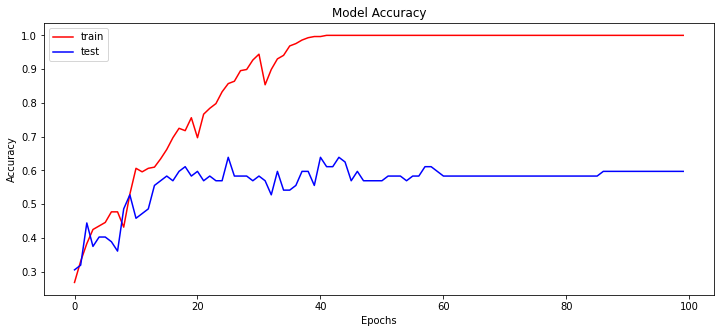

In [54]:
#plot the training history
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'])
plt.show()

In [56]:
#Predictions
Y_pred = model.predict(X_test)
score = model.evaluate(X_test,Y_test)
print('Accuracy over test set: ',score)

3/3 [==============================] - 2s 609ms/step - loss: 3.1949 - accuracy: 0.5972
Accuracy over test set:  [3.1949195861816406, 0.5972222089767456]


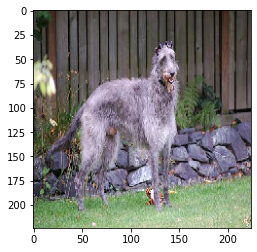

original value:  scottish_deerhound
Predicted value:  scottish_deerhound


In [59]:
#plotting the images to compare
plt.imshow(X_test[3,:,:,:])
plt.show()

#Comparing the original value and predicted value
print('original value: ',selected_labels['breed'][np.argmax(Y_test[3])])
print('Predicted value: ',selected_labels['breed'][np.argmax(Y_pred[3])])

In [60]:
#Saving the model to create streamlit app
model.save('dog_breed.h5')